<a href="https://colab.research.google.com/github/gh-ita/SafetyScan/blob/main/train_RF-DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install mlflow rfdetr supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.8 MB/s eta 0:00:0

In [5]:
from rfdetr import RFDETRBase
import mlflow
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision
from PIL import Image
import os
import matplotlib.pyplot as plt

In [6]:
DATA = "/content/drive/MyDrive/PPEData/dataset"
EPOCHS = 100
BATCH = 4
LR = 1e-4
GRAD_ACCUM_STEPS = 4
EXPERIMENTATION = "PPE_detection_data_version 1/detect/yolo"
TRAIN_NAME = "train_RF_DETR_BASE"
TEST_NAME =  "train_RF_DETR_BASE2"
OUTPUT_DIR = "/content/drive/MyDrive/PPE_detection_data_version 1/detect/yolo/train_RF_DETR_BASE"
EARLY_STOPPING = True

In [9]:
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment(EXPERIMENTATION)

with mlflow.start_run(run_name = TRAIN_NAME) as run :
    mlflow.log_param("Epochs", EPOCHS)
    mlflow.log_param("Batch", BATCH)
    mlflow.log_param("learning_rate", LR)
    mlflow.log_param("Gradient_accumulation_steps", GRAD_ACCUM_STEPS)
    model = RFDETRBase()
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    model.train(dataset_dir = DATA,
                epochs = EPOCHS,
                batch_size = BATCH,
                grad_accum_steps = GRAD_ACCUM_STEPS,
                lr = LR,
                early_stopping = EARLY_STOPPING,
                output_dir = OUTPUT_DIR)

    targets = []
    predictions = []
    ds = sv.DetectionDataset.from_coco(
        images_directory_path = f"{DATA}/test" ,
        annotations_path = f"{DATA}/test/annotations.coco.json" ,
    )

    for path, image, annotations in tqdm(ds):
        image = Image.open(path)
        detections = model.predict(image, threshold = 0.5)

        targets.append(annotations)
        predictions.append(detections)

    #compute mAP
    map_metric = MeanAveragePrecision()
    map_result = map_metric.update(predictions, targets).compute()
    mlflow.log_metric("test_mAP", map_result["mAP"])
        #plot mAP
    map_fig = map_result.plot()
    map_plot_path = os.path.join(OUTPUT_DIR, "map_plot.png")
    map_fig.savefig(map_plot_path)
    plt.close(map_fig)

    #compute confusion matrix
    confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
    )

    #plot confusion matrix
    cm_fig = confusion_matrix.plot()
    cm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
    cm_fig.savefig(cm_plot_path)
    plt.close(cm_fig)

    #log artifacts
    mlflow.log_artifacts(OUTPUT_DIR, 'training_artifact')



Loading pretrain weights


reinitializing your detection head with 11 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir /content/drive/MyDrive/PPE_detection_data_version 1/detect/yolo/train_RF_DETR_BASE' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=11, grad_accum_steps=4, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=100, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-base.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[2, 5, 8, 11], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False

Epoch: [0]  [ 0/29]  eta: 0:11:46  lr: 0.000100  class_error: 92.62  loss: 14.0737 (14.0737)  loss_ce: 0.6211 (0.6211)  loss_bbox: 1.0947 (1.0947)  loss_giou: 1.5778 (1.5778)  loss_ce_0: 0.5764 (0.5764)  loss_bbox_0: 1.3851 (1.3851)  loss_giou_0: 1.6725 (1.6725)  loss_ce_1: 0.6287 (0.6287)  loss_bbox_1: 1.1715 (1.1715)  loss_giou_1: 1.5657 (1.5657)  loss_ce_enc: 0.5560 (0.5560)  loss_bbox_enc: 1.4766 (1.4766)  loss_giou_enc: 1.7473 (1.7473)  loss_ce_unscaled: 0.6211 (0.6211)  class_error_unscaled: 92.6154 (92.6154)  loss_bbox_unscaled: 0.2189 (0.2189)  loss_giou_unscaled: 0.7889 (0.7889)  cardinality_error_unscaled: 3069.2500 (3069.2500)  loss_ce_0_unscaled: 0.5764 (0.5764)  loss_bbox_0_unscaled: 0.2770 (0.2770)  loss_giou_0_unscaled: 0.8363 (0.8363)  cardinality_error_0_unscaled: 3430.2500 (3430.2500)  loss_ce_1_unscaled: 0.6287 (0.6287)  loss_bbox_1_unscaled: 0.2343 (0.2343)  loss_giou_1_unscaled: 0.7829 (0.7829)  cardinality_error_1_unscaled: 3093.0000 (3093.0000)  loss_ce_enc_unsca

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PPEData/dataset/test/annotations.coco.json'

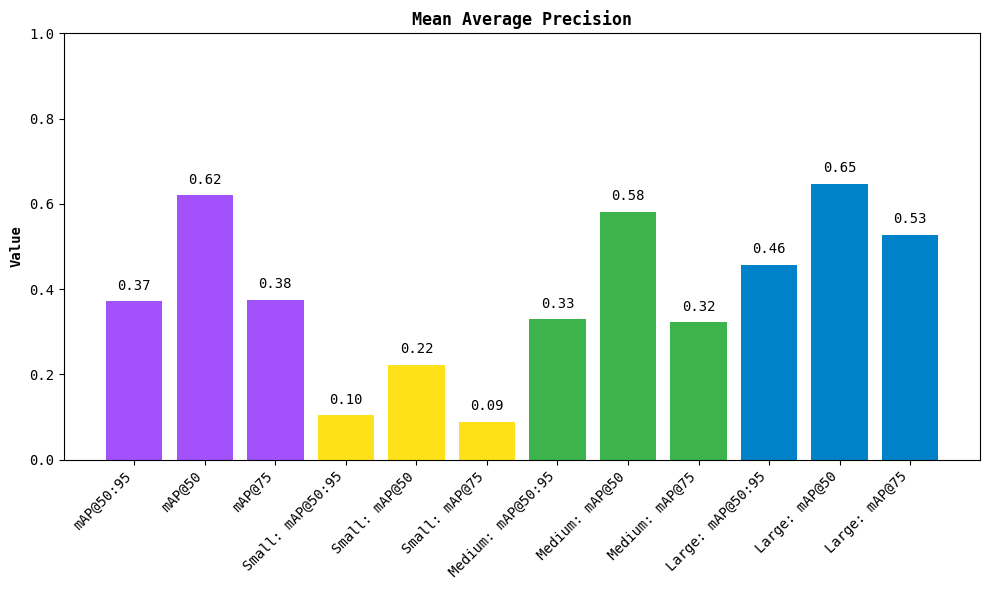

In [14]:
"""model = RFDETRBase(pretrain_weights = "/content/drive/MyDrive/PPE_detection_data_version 1/detect/yolo/train_RF_DETR_BASE/checkpoint_best_total.pth")
targets = []
predictions = []
ds = sv.DetectionDataset.from_coco(
    images_directory_path = f"{DATA}/test" ,
    annotations_path = f"{DATA}/test/annotations.coco.json" ,
)

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold = 0.5)

    targets.append(annotations)
    predictions.append(detections)

#compute mAP"""
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
mlflow.log_metric("test_mAP", map_result.map50_95)
#plot mAP
map_result.plot()
map_plot_path = os.path.join(OUTPUT_DIR, "map_plot.png")
plt.savefig(map_plot_path)
plt.close()

#compute confusion matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
predictions=predictions,
targets=targets,
classes=ds.classes
)

#plot confusion matrix
cm_fig = confusion_matrix.plot()
cm_plot_path = os.path.join(OUTPUT_DIR, "confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.close(cm_fig)

#log artifacts
mlflow.log_artifacts(OUTPUT_DIR, 'training_artifact')